# Experiment 1a: the influence of a stable confounder on classification performance

In this experiment, we use a simplified causal graph consisting of three nodes: immune state, sex, and AIRR, to show if the distribution of a confounder is stable in the study cohort, and source and target populations, it does not influence the prediction task.

Immune state is a binary variable and can have values `True` or `False` to indicate if an individual is diseased or healthy. Confounder also in this setting has two values: `C1` and `C2`. AIRR is a set of sequences simulated based on the values of the immune state and the confounder for the given individual.

Steps:

1. Simulate training and test dataset from a causal graph to include: confounder (implemented by implanting 3-mer `ADR` in the repertoire), immune state (implemented by implanting a signal in the repertoire but the exact 3-mer depends on the value of the confounder; it is either `QPR` or `EQY`)

2. Train an ML model (here: logistic regression on repertoires represented by the k-mer frequencies) on the train set and assess its performance on the test set in the presence of confounder with stable distribution across train and test.

Software used: 

- DagSim for simulation of the causal graph; 
- immuneML v2.1 for implanting signal in AIRRs and for training and assessing machine learning classifiers; 
- OLGA for simulation of naive AIRRs

In [1]:
import yaml
import dagsim.base as ds
import numpy as np
from util.dataset_util import make_AIRR_dataset, make_dataset, setup_path
from util.implanting import make_immune_state_signals, make_confounding_signal
from util.experiment1 import get_immune_state, get_confounder, get_repertoire

## Step 1: AIRR simulation from a causal graph

In [2]:
result_path = setup_path('./experiment1a/')
data_path = setup_path("./experiment1a/data/")

# how many repertoires to make for training and testing
train_example_count = 200
test_example_count = 100

# immune state: two binomial distributions depending on the confounder value with probability of success p
immune_state_p_conf1 = 0.75 # for confounder = C1
immune_state_p_conf2 = 0.25 # for confounder = C2

# confounder: binomial distribution with probability of success p
confounder_p_train = 0.6
confounder_p_test = 0.6

# other parameters
immune_state_implanting_rate = 0.02 # percentage of repertoire sequences to include immune state signal
confounding_implanting_rate = 0.2
sequence_count = 500 # number of sequences in one repertoire

Removing experiment1a...


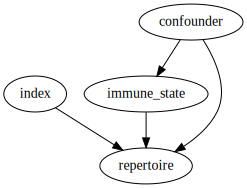

In [3]:
immune_state_signal_name = "immune_state"
immune_state_signals = make_immune_state_signals(signal_name=immune_state_signal_name)
confounding_signal = make_confounding_signal()

# define nodes of the causal graph

index_node = ds.Generic(name="index", function=np.arange, size_field="stop")

confounder_node = ds.Generic(name="confounder", function=get_confounder, arguments={"p": confounder_p_train})

immune_state_node = ds.Generic(name="immune_state", function=get_immune_state, 
                               arguments={"confounder": confounder_node, "p_conf1": immune_state_p_conf1,
                                         "p_conf2": immune_state_p_conf2})

repertoire_node = ds.Generic(name="repertoire", function=get_repertoire, 
                             arguments={"immune_state": immune_state_node, "confounder": confounder_node, 
                                        "path": data_path / "train", "sequence_count": sequence_count, 
                                        "immune_state_signals": immune_state_signals, 
                                        "confounding_signal": confounding_signal, "seed": index_node, 
                                        'immune_state_implanting_rate': immune_state_implanting_rate, 
                                        'confounding_implanting_rate': confounding_implanting_rate})

# make a causal graph using DagSim and show it graphically

graph = ds.Graph(name="graph_experiment_1a", 
                 list_nodes=[index_node, confounder_node, immune_state_node, repertoire_node])
graph.draw()


In [4]:
# simulate a dataset using the graph

study_cohort_data = graph.simulate(num_samples=train_example_count, 
                                   csv_name=str(data_path / "train/study_cohort"))

# make an AIRR dataset from the generated repertoires to be used for training

train_dataset = make_dataset(repertoire_paths=study_cohort_data["repertoire"], path=data_path / 'train', 
                             dataset_name="experiment1a_train", 
                             signal_names=[immune_state_signal_name, confounder_node.name])

# make a test dataset

repertoire_node.additional_parameters['path'] = data_path / 'test' # update result_path: to be removed with DagSim update
confounder_node.additional_parameters['p'] = confounder_p_test # update the confounder distribution parameter for test

test_data = graph.simulate(num_samples=test_example_count, csv_name=str(data_path / "test/test_cohort"))

test_dataset = make_dataset(repertoire_paths=test_data["repertoire"], path=data_path / 'test', 
                            dataset_name="experiment1a_test", 
                            signal_names=[immune_state_signal_name, confounder_node.name])

# merge datasets (but the distinction between train and test will be kept)

dataset = make_AIRR_dataset(train_dataset, test_dataset, data_path / 'full_dataset')

## Step 2: train an ML model and assess performance

In [13]:
specs = {
    "definitions": {
        "datasets": {
            "dataset1": {
                "format": 'AIRR',
                "params": {
                    "path": str(data_path / 'full_dataset'),
                    "metadata_file": str(data_path / 'full_dataset/metadata.csv')
                }
            }
        },
        "encodings": {
            "kmer_frequency": {
                "KmerFrequency": {"k": 3}
            }
        },
        "ml_methods": {
            "logistic_regression": {
                "LogisticRegression": {
                    "penalty": "l1",
                    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    "show_warnings": False
                },
                "model_selection_cv": True,
                "model_selection_n_folds": 5
            }
        },
        "reports": {
            "motif_recovery": { # to check how much coefficients overlap with the immune state signal that was implanted
                "MotifSeedRecovery": {
                    "implanted_motifs_per_label": {
                        "immune_state": {
                            "seeds": ["EQY", "QPR"],
                            "hamming_distance": False,
                            "gap_sizes": [0] # no gaps
                        },
                        "confounder": {
                            "seeds": ["ADR"],
                            "hamming_distance": False,
                            "gap_sizes": [0] # no gaps
                        }
                    }
                }
            },
            "coefficients": {
                "Coefficients": { # show top 25 logistic regression coefficients and what k-mers they correspond to
                    "coefs_to_plot": ['n_largest'],
                    "n_largest": [25]
                }
            },
            "feature_comparison": {
                "FeatureComparison": {
                    "comparison_label": "immune_state",
                    "color_grouping_label": "sex",
                    "show_error_bar": False,
                    "keep_fraction": 0.1,
                    "log_scale": True
                }
            }, 
            "training_performance": {
                "TrainingPerformance": {
                    "metrics": ["balanced_accuracy", "log_loss", "auc"]
                }
            }
        }
    },
    "instructions": {
        'train_ml': {
            "type": "TrainMLModel",
            "assessment": { # ensure here that train and test dataset are fixed, as per simulation
                "split_strategy": "manual",
                "split_count": 1,
                "manual_config": {
                    "train_metadata_path": str(data_path / "train/experiment1a_train_metadata.csv"),
                    "test_metadata_path": str(data_path / "test/experiment1a_test_metadata.csv")
                },
                "reports": {
                    "models": ["coefficients", "motif_recovery", "training_performance"],
                    "encoding": ["feature_comparison"]
                }
            },
            "selection": {
                "split_strategy": "k_fold",
                "split_count": 5,
                "reports": {
                    "models": ["coefficients", "motif_recovery", "training_performance"],
                    "encoding": ["feature_comparison"]
                }
            },
            "settings": [
                {"encoding": "kmer_frequency", "ml_method": "logistic_regression"}
            ],
            "dataset": "dataset1",
            "refit_optimal_model": False,
            "labels": ["immune_state"],
            "optimization_metric": "balanced_accuracy",
            "metrics": ['log_loss', 'auc']
        }
    }
}

ml_result_path = setup_path("./experiment1a/ml_result/")
specification_path = ml_result_path / "specs.yaml"

with open(specification_path, "w") as file:
    yaml.dump(specs, file)

Removing experiment1a/ml_result...


In [14]:
# run immuneML with the specs file

from immuneML.app.ImmuneMLApp import ImmuneMLApp

output_path = ml_result_path / "result/"

app = ImmuneMLApp(specification_path = specification_path, result_path = output_path)
result = app.run()

print("The results are located under ./experiment1a/")

2021-12-29 12:07:55.369541: Setting temporary cache path to experiment1a/ml_result/result/cache
2021-12-29 12:07:55.370254: ImmuneML: parsing the specification...

2021-12-29 12:08:15.163758: Full specification is available at experiment1a/ml_result/result/full_specs.yaml.

2021-12-29 12:08:15.165067: ImmuneML: starting the analysis...

2021-12-29 12:08:15.165609: Instruction 1/1 has started.
2021-12-29 12:08:15.258739: Training ML model: running outer CV loop: started split 1/1.

2021-12-29 12:08:15.355989: Hyperparameter optimization: running the inner loop of nested CV: selection for label immune_state (label 1 / 1).

2021-12-29 12:08:15.357518: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-12-29 12:08:15.359341: Encoding started...
2021-12-29 12:08:20.788175: Encoding finished.
2021-12-29 12:08:20.788632: ML model training started...
2021-12-29 12:09:00.219772: ML model training finished.
      feature    sex  immune_state_x  valuemean_x  valuestd_x 

2021-12-29 12:10:14.044402: Encoding finished.
      feature    sex  immune_state_x  valuemean_x  valuestd_x  immune_state_y  \
1854      DKH  False           False     4.464777    3.157096            True   
1184      CMR  False           False     4.206576    5.948997            True   
14264     WIM  False           False     4.173495    5.902213            True   
2720      EMF  False           False     4.062700    5.745526            True   
9352      PEM  False           False     4.591104    3.246423            True   
...       ...    ...             ...          ...         ...             ...   
8295      MSF   True           False     0.000000    0.000000            True   
8292      MSE  False           False     0.000000    0.000000            True   
8291      MSD   True           False     0.000000    0.000000            True   
8289      MSA   True           False     0.000000    0.000000            True   
3512      FMH  False           False     0.000000    0.000000 

2021-12-29 12:11:19.444862: Completed hyperparameter setting kmer_frequency_logistic_regression.

2021-12-29 12:11:19.446613: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-12-29 12:11:19.447843: Encoding started...
2021-12-29 12:11:22.449577: Encoding finished.
2021-12-29 12:11:22.449810: ML model training started...
2021-12-29 12:11:59.708640: ML model training finished.
      feature    sex  immune_state_x  valuemean_x  valuestd_x  immune_state_y  \
10520     QPR  False           False     0.117844    0.139438            True   
10781     QYG   True           False     0.209368    0.418813            True   
1480      CWP  False           False     1.843084    3.192357            True   
12726     TIW  False           False     1.776894    2.722754            True   
10797     QYQ   True           False     0.074195    0.337346            True   
...       ...    ...             ...          ...         ...             ...   
7760      LWW  False      

2021-12-29 12:13:05.025309: Encoding finished.
      feature    sex  immune_state_x  valuemean_x  valuestd_x  immune_state_y  \
4702      HAM  False           False     4.435486    6.272725            True   
15154     YMF  False           False     4.353079    6.156183            True   
7768      LYM  False           False     4.353079    6.156183            True   
10740     QWI  False           False     4.261211    6.026262            True   
8952      NQH  False           False     4.217410    5.964318            True   
...       ...    ...             ...          ...         ...             ...   
8543      NDL   True           False     0.000000    0.000000            True   
3531      FND   True           False     0.000000    0.000000            True   
8542      NDL  False           False     0.000000    0.000000            True   
7231      LHC   True           False     0.000000    0.000000            True   
7802      MAI  False           False     0.000000    0.000000 

2021-12-29 12:14:20.356052: Completed hyperparameter setting kmer_frequency_logistic_regression.

2021-12-29 12:14:20.357136: Training ML model: running the inner loop of nested CV: completed retraining models for label immune_state (label 1 / 1).

2021-12-29 12:14:20.357663: Training ML model: running outer CV loop: finished split 1/1.

Performances (balanced_accuracy) -----------------------------------------------


Label: immune_state
Performance (balanced_accuracy) per assessment split:
Split 1: 0.94
Average performance (balanced_accuracy): 0.94
------------------------------
2021-12-29 12:14:20.699958: Instruction 1/1 has finished.
2021-12-29 12:14:20.714008: Generating HTML reports...
2021-12-29 12:14:21.669996: HTML reports are generated.
2021-12-29 12:14:21.749796: ImmuneML: finished analysis.

The results are located under ./experiment1a/


In [15]:
from util.plotting import plot_validation_vs_test_performance

plot_validation_vs_test_performance(iml_result=result, result_path=ml_result_path)

In [16]:
# show what the model has learned

from IPython.display import IFrame


IFrame(src=str(ml_result_path / "result/HTML_output/train_ml_split_1_immune_state_kmer_frequency_logistic_regression_optimal_reports_ml_method_coefficients_largest_25_coefficients.html"),  width=700, height=600)